In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pyTVDN.tmpUtils import *
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict as ddict
from tqdm import tqdm_notebook as tqdm
import pickle
from scipy.signal import lfilter, firls, decimate
from numpy.linalg import inv, svd
%matplotlib inline
plt.style.use('ggplot')

In [3]:
saveDir = Path("../results/fMRIHPFs_rankAdap")
fil = list(saveDir.glob("*AdapM8.pkl"))[0]
print(fil)

with open(fil, "rb") as f:
    TVDNres = pickle.load(f)

../results/fMRIHPFs_rankAdap/fMRIResultAdapM8.pkl


In [4]:
import rpy2.robjects as robj
robj.r.source("../Rcode/utils.R")

RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]

# Distribution of num of changes and ranks

In [5]:
wsizes = [5, 10, 20, 35, 50, 100]
rank = 0
numChgswAll = {}

for wsize in wsizes:
    numChgsw = ddict(list)
    for DetObj in tqdm(TVDNres.DetObjs):
        Ymat = DetObj.Ymat
        d, n = Ymat.shape
        seqw = np.arange(1, n-wsize, 4)
        rSeqw = py2Rvec(seqw)
        rYmat = py2Rmat(Ymat)
        
        
        rDCORres = RsegCorr(rYmat, wsize, rSeqw)
        rDCORecpts = RchgF(rDCORres, rSeqw)
        numChgsw["DCOR"].append(np.array(rDCORecpts))
        
        # Detection results for PCA
        rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=rank)
        rPCAecpts = RchgF(rPCAres, rSeqw)
        numChgsw["PCA"].append(np.array(rPCAecpts))
        
        # Detection results for DMD
        rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
        rDMDecpts = RchgF(rDMDres, rSeqw)
        numChgsw["DMD"].append(np.array(rDMDecpts))
        
    numChgswAll[wsize] = numChgsw

R[write to console]: Error in sample.int(m, k) : 
  cannot take a sample larger than the population when 'replace = FALSE'
Calls: <Anonymous> -> kmeans -> sample.int



RRuntimeError: Error in sample.int(m, k) : 
  cannot take a sample larger than the population when 'replace = FALSE'
Calls: <Anonymous> -> kmeans -> sample.int


In [10]:
numChgsCTAll = {}

for wsize in wsizes:
    numChgsCT = {}
    for key, v in numChgswAll[wsize].items():
        CT = Counter([len(ecpt) for ecpt in v])
        chgs = list(CT.keys())
        chgCts = [CT[chg] for chg in chgs]
        numChgsCT[key] = [chgs, chgCts]
        
    numChgsCTAll[wsize] = numChgsCT

### Ranks and num of changes for TVDN

In [11]:
numChgs = []
numRanks = []
for DetObj in TVDNres.DetObjs:
    numChgs.append(len(DetObj.ecpts))
    numRanks.append(DetObj.paras.r)
    
numChgsCt = Counter(numChgs)
numRanksCt = Counter(numRanks)

ranks = list(numRanksCt.keys())
ranks = sorted(ranks)
rCts = [numRanksCt[r] for r in ranks]

chgs = list(numChgsCt.keys())
chgCts = [numChgsCt[chg] for chg in chgs]

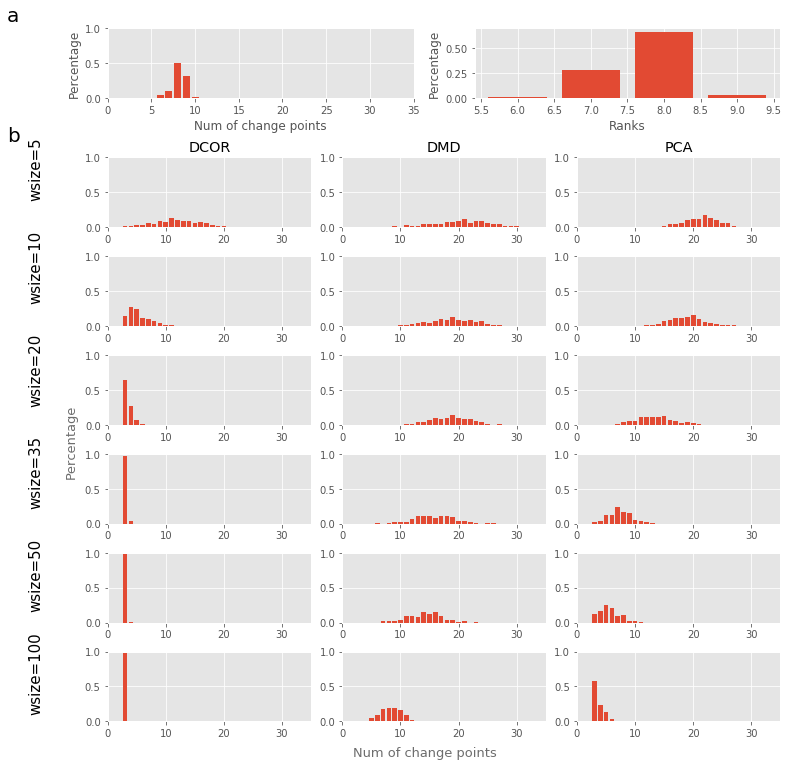

In [87]:
from matplotlib import gridspec
numData = len(TVDNres.DetObjs)

wsizesplot = wsizes#[:-1]

fig = plt.figure(figsize=(10, 10), constrained_layout=True)

gs = gridspec.GridSpec(1+len(wsizesplot), 6, figure=fig)

ax0 = plt.subplot(gs[0,:3])
ax1 = plt.subplot(gs[0,3:])
#axErr = plt.subplot(gs[0,4:])
#
#axErr.plot(numPts, mDMDErr, "--o", label="DMD")
#axErr.plot(numPts, mTVDNErr, "-h", label="TVDN")
#axErr.set_xticks(numPts[::5])
#axErr.legend()

ax2 = plt.subplot(gs[1,0:2])
ax3 = plt.subplot(gs[1,2:4], sharex=ax2, sharey=ax2)
ax4 = plt.subplot(gs[1,4:6], sharex=ax2, sharey=ax2)
ax1s = [ax2]
ax2s = [ax3]
ax3s = [ax4]
for ii in range(len(wsizesplot)-1):
    ax1s.append(plt.subplot(gs[ii+2,0:2], sharex=ax2, sharey=ax2))
    ax2s.append(plt.subplot(gs[ii+2,2:4], sharex=ax2, sharey=ax2))
    ax3s.append(plt.subplot(gs[ii+2,4:6], sharex=ax2, sharey=ax2))
    
ax0.bar(chgs, np.array(chgCts)/numData)
ax0.set_xlabel("Num of change points")
ax0.set_ylabel("Percentage")
ax0.set_ylim([0, 1])
ax0.set_xlim([0, 35])

ax1.bar(ranks, np.array(rCts)/numData)
ax1.set_xlabel("Ranks")
ax1.set_ylabel("Percentage")

for iidx, wsize in enumerate(wsizesplot):
    ax1s[iidx].bar(numChgsCTAll[wsize]["DCOR"][0], np.array(numChgsCTAll[wsize]["DCOR"][1])/numData)
    ax2s[iidx].bar(numChgsCTAll[wsize]["DMD"][0], np.array(numChgsCTAll[wsize]["DMD"][1])/numData)
    ax3s[iidx].bar(numChgsCTAll[wsize]["PCA"][0], np.array(numChgsCTAll[wsize]["PCA"][1])/numData)
    if iidx == 0:
        ax1s[iidx].set_ylim([0, 1])
        ax1s[iidx].set_xlim([0, 35])
        ax1s[iidx].set_title("DCOR")
        #ax1s[iidx].tick_params(labelbottom=False) # remove the axis labels
        ax2s[iidx].set_title("DMD")
        ax3s[iidx].set_title("PCA")


fig.text(-0.08, 1, "a", fontsize=20)
fig.text(-0.08, 5/6, "b", fontsize=20)

fig.text(0.5, -0.02, 'Num of change points', ha='center', fontsize=13, color="#6D6D6D")
fig.text(0, 5/12, 'Percentage', va='center', rotation="vertical", fontsize=13, color="#6D6D6D")

for ii, wsize in enumerate(wsizesplot[::-1]):
    fig.text(-0.05, 1/24+ii*1/(len(wsizesplot)+1), f"wsize={wsize}", rotation="vertical", fontsize=15)

# Reconstructed Error vs num of change (DMD and TVDN)

In [69]:
tmpwsizes = [130, 140, 150]
ncens = [3, 2, 1]
for ncen, wsize in zip(ncens, tmpwsizes):
    restmp = ddict(list)
    for DetObj in tqdm(TVDNres.DetObjs):
        Ymat = DetObj.Ymat
        d, n = Ymat.shape
        seqw = np.arange(1, n-wsize, 4)
        rSeqw = py2Rvec(seqw)
        rYmat = py2Rmat(Ymat)
        rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
        rDMDecpts = RchgF(rDMDres, rSeqw, ncen)
        restmp["DMD"].append(np.array(rDMDecpts))
    numChgswAll[wsize] = restmp
    

In [70]:
# Obtain the Rec Error for DMD
DMDRecErrs = ddict(list)
wsizesF = np.concatenate([wsizes, tmpwsizes])
for wsize in tqdm(wsizesF):
    ii = 0
    for DetObj in TVDNres.DetObjs:
        Ymat = DetObj.nYmat
        ecpts = numChgswAll[wsize]["DMD"][ii]
        ecpts = ecpts.astype(np.int)
        numC = len(ecpts)
        YmatPred = PredDMD(Ymat, ecpts)
        YmatPred = detrend(YmatPred)
        err = np.sqrt(np.sum((Ymat-YmatPred)**2)/np.sum(Ymat**2))
        DMDRecErrs[numC].append(err)
        ii += 1

In [16]:
# Recon segment-wisely with half data
TVDNRecErrsSW = ddict(list)
for DetObj in tqdm(TVDNres.DetObjs):
    Ymat = DetObj.nYmat
    chgMat = DetObj.finalRes.chgMat
    ndXmat = DetObj.midRes.ndXmat
    nXmat = DetObj.midRes.nXmat
    kpidxs = DetObj.midRes.kpidxs
    eigVecs = DetObj.midRes.eigVecs
    r = DetObj.paras.r
    tStep = np.diff(DetObj.time)[0]
    for ii in range(21):
        YmatPred = ReconXmatSWHalf(chgMat[ii-1, :ii], ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r=r, is_full=True)
        YmatPred = YmatPred.EstXmatReal
        err = np.sqrt(np.sum((Ymat-YmatPred)**2)/np.sum(Ymat**2))
        TVDNRecErrsSW[ii].append(err)

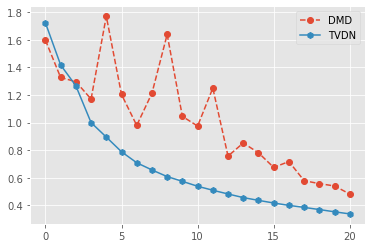

In [85]:
numPts = list(range(0, 21))
mDMDErr = [np.mean(DMDRecErrs[i]) for i in numPts]
mTVDNErr = [np.mean(TVDNRecErrsSW[i]) for i in numPts]

plt.plot(numPts, mDMDErr, "--o", label="DMD")
plt.plot(numPts, mTVDNErr, "-h", label="TVDN")
plt.xticks(numPts[::5])
plt.legend()

# Correlation with the 7 canonical networks

In [76]:
import pandas as pd

def tmpF(name):
    splName = name.split("_")
    if len(splName) == 1:
        return splName[0]
    else:
        res = splName[0] 
        for splNam in splName[1:]:
            res = res + " " + splNam
        return res 

fcR = pd.read_csv("../necessary files/AALICA.csv")
names = list(fcR.columns)
names = [tmpF(name.strip()) for name in names]
fcR = np.array(fcR)
fcR = fcR[:90, :]

RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]
RcorF = robj.r["corF.fMRI"]

In [79]:
featuresWAll = {}
corWAll = {}
for wsize in [10, 20]:
    featuresW = ddict(list)
    corW = ddict(list)
    for DetObj in tqdm(TVDNres.DetObjs):
        Ymat = DetObj.Ymat
        d, n = Ymat.shape
        seqw = np.arange(1, n-wsize, 4)
        rSeqw = py2Rvec(seqw)
        rYmat = py2Rmat(Ymat)
        rfcR = py2Rmat(fcR)
        
        # Features and correlations for PCA
        rPCAres = RsegPCAOrg(rYmat, wsize, rSeqw, rank=rank)
        featuresW["PCA"].append(np.array(rPCAres))
        rPCAres = RcorF(rPCAres, rfcR)
        corW["PCA"].append(np.array(rPCAres))
        
        # Features and correlations for DMD
        rDMDres = RsegDMDOrg(rYmat, wsize, rSeqw, rank=rank)
        featuresW["DMD"].append(np.array(rDMDres))
        rDMDres = RcorF(rDMDres, rfcR)
        corW["DMD"].append(np.array(rDMDres))
        
    corWAll[wsize] = corW
    featuresWAll[wsize] = featuresW

In [81]:
DMDw10Cors = np.concatenate(corWAll[10]["DMD"])
PCAw10Cors = np.concatenate(corWAll[10]["PCA"])
DMDw20Cors = np.concatenate(corWAll[20]["DMD"])
PCAw20Cors = np.concatenate(corWAll[20]["PCA"])
TVDNCors = np.loadtxt(saveDir/"allCorrUM8.txt")

DMDw10CorM = np.max(DMDw10Cors, axis=1)
PCAw10CorM = np.max(PCAw10Cors, axis=1)
DMDw20CorM = np.max(DMDw20Cors, axis=1)
PCAw20CorM = np.max(PCAw20Cors, axis=1)
TVDNCorM = np.max(TVDNCors, axis=1)

rawVs = list(TVDNCorM) + list(DMDw10CorM) + list(DMDw20CorM) + list(PCAw10CorM) + list(PCAw20CorM)
labs = ["TVDN"]*len(TVDNCorM) + ["DMD wsize=10"]* len(DMDw10CorM) + ["DMD wsize=20"]* len(DMDw20CorM) + \
       ["PCA wsize=10"]*len(PCAw10CorM) +  ["PCA wsize=20"]*len(PCAw20CorM)

In [82]:
maxPosIdxDMDw10 = np.argmax(DMDw10Cors, axis=1)
maxPosIdxPCAw10 = np.argmax(PCAw10Cors, axis=1)
maxPosIdxDMDw20 = np.argmax(DMDw20Cors, axis=1)
maxPosIdxPCAw20 = np.argmax(PCAw20Cors, axis=1)
maxPosIdxTVDN = np.argmax(TVDNCors, axis=1)

PosPCAw10CT = Counter(maxPosIdxPCAw10)
PosDMDw10CT = Counter(maxPosIdxDMDw10)
PosPCAw20CT = Counter(maxPosIdxPCAw20)
PosDMDw20CT = Counter(maxPosIdxDMDw20)
PosTVDNCT = Counter(maxPosIdxTVDN)
barPosPCAw10 = [PosPCAw10CT[i]/len(maxPosIdxPCAw10) for i in range(7)]
barPosDMDw10 = [PosDMDw10CT[i]/len(maxPosIdxDMDw10) for i in range(7)]
barPosPCAw20 = [PosPCAw20CT[i]/len(maxPosIdxPCAw20) for i in range(7)]
barPosDMDw20 = [PosDMDw20CT[i]/len(maxPosIdxDMDw20) for i in range(7)]
barPosTVDN = [PosTVDNCT[i]/len(maxPosIdxTVDN) for i in range(7)]

Text(-0.05, 0.12, 'wsize=20')

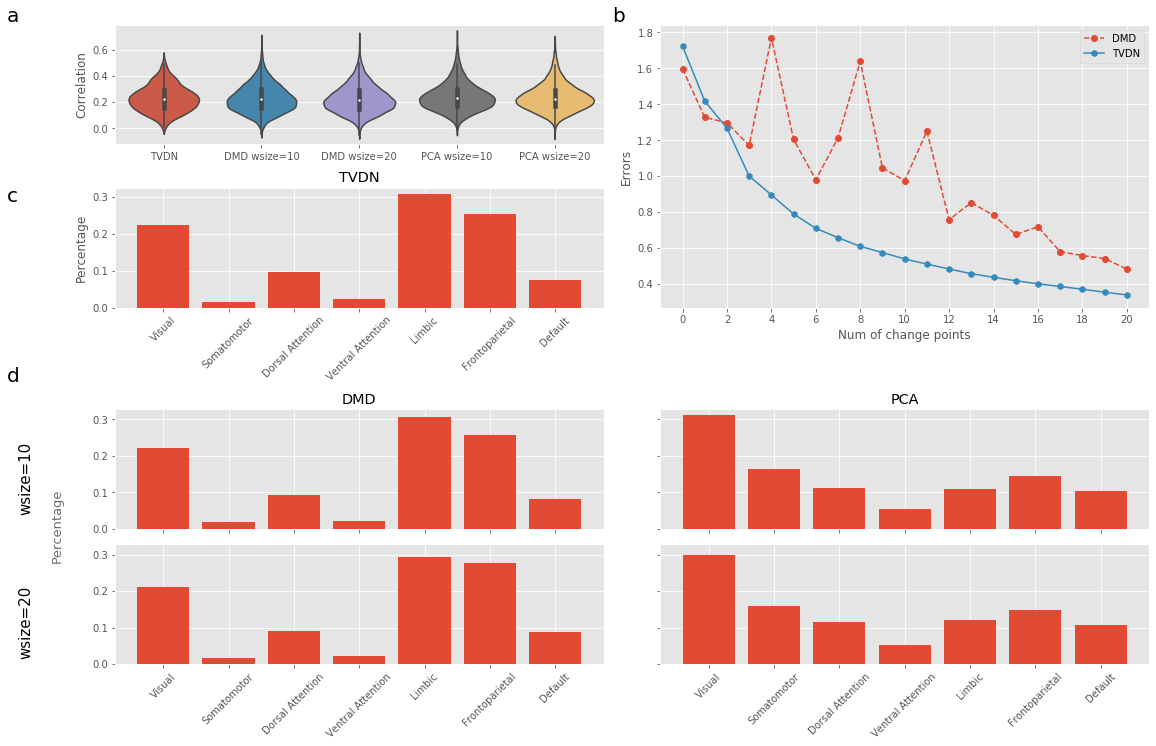

In [96]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)

gs = gridspec.GridSpec(4, 2, figure=fig)

ax0 = plt.subplot(gs[0, 0])
sns.violinplot(y=rawVs, x=labs)
_ = plt.ylabel("Correlation")

ax1 = plt.subplot(gs[1,0])
ax1.bar(names, barPosTVDN)
ax1.set_ylabel("Percentage")
ax1.set_title("TVDN")
ax1.set_xticklabels(names, rotation=45)

ax2 = plt.subplot(gs[2, 0])
ax3 = plt.subplot(gs[2, 1], sharex=ax2, sharey=ax2)
ax4 = plt.subplot(gs[3, 0], sharex=ax2, sharey=ax2)
ax5 = plt.subplot(gs[3, 1], sharex=ax2, sharey=ax2)

ax2.bar(names, barPosDMDw10)
ax2.set_title("DMD")
ax2.tick_params(labelbottom=False)

ax3.bar(names, barPosPCAw10)
ax3.set_title("PCA")
ax3.tick_params(labelbottom=False, labelleft=False)


ax4.bar(names, barPosDMDw20)
ax4.set_xticklabels(names, rotation=45)

ax5.bar(names, barPosPCAw20)
ax5.tick_params(labelleft=False)
ax5.set_xticklabels(names, rotation=45)

ax6 = plt.subplot(gs[:2, 1])
ax6.plot(numPts, mDMDErr, "--o", label="DMD")
ax6.plot(numPts, mTVDNErr, "-h", label="TVDN")
ax6.set_xticks(numPts[::2])
ax6.set_ylabel("Errors")
ax6.set_xlabel("Num of change points")
ax6.legend()

fig.text(0.50, 1, "b", fontsize=20)
fig.text(-0.06, 1, "a", fontsize=20)
fig.text(-0.06, 0.75, "c", fontsize=20)
fig.text(-0.06, 0.50, "d", fontsize=20)

fig.text(-0.02, 0.30, 'Percentage', va='center', rotation="vertical", fontsize=13, color="#6D6D6D")

fig.text(-0.05, 0.32, "wsize=10", rotation="vertical", fontsize=15)
fig.text(-0.05, 0.12, "wsize=20", rotation="vertical", fontsize=15)

## Demo result: fMRI  121

### Results for DCOR, DMD and PCA

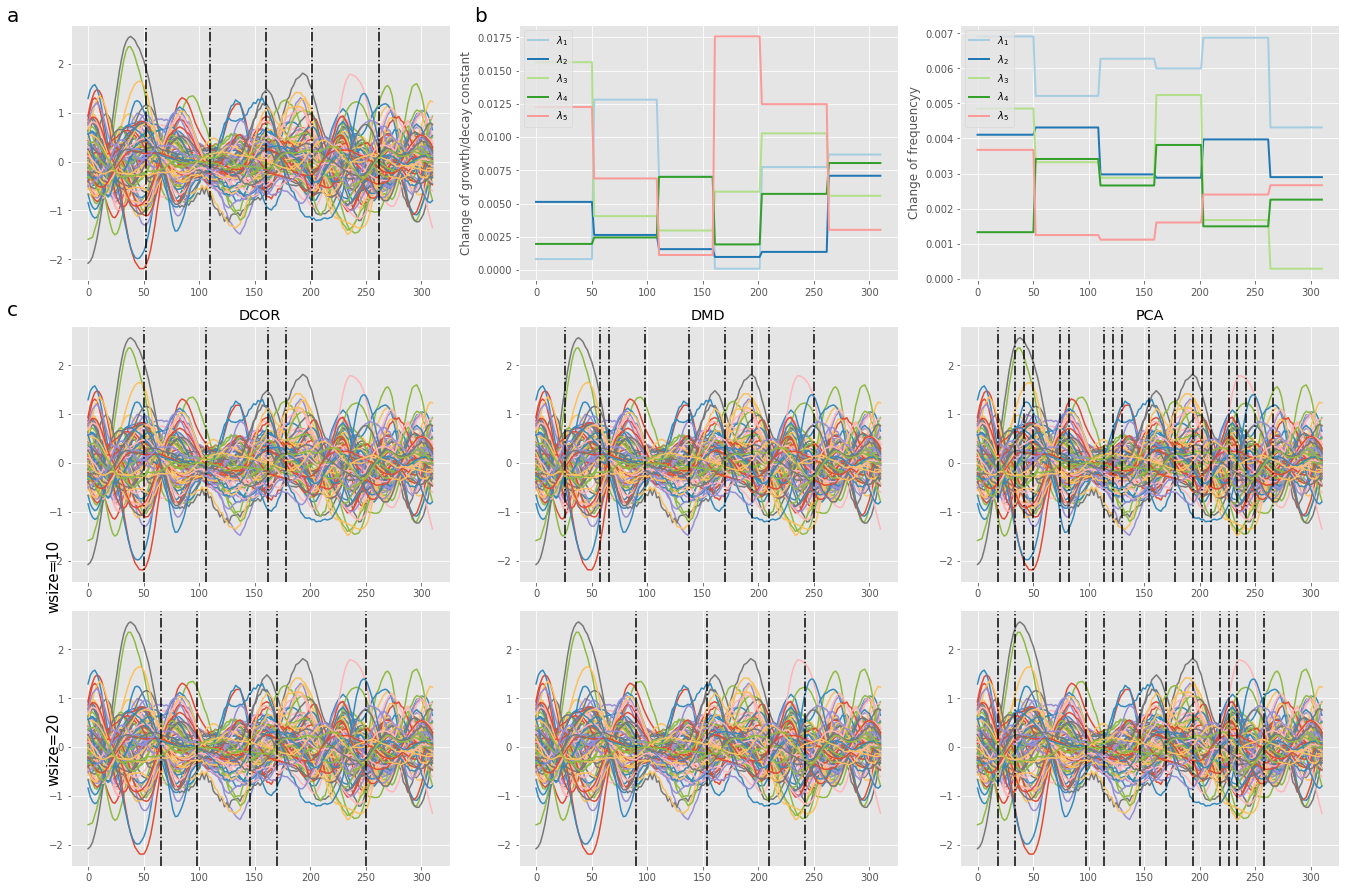

In [42]:
idx = 121
DetObj = TVDNres.DetObjs[idx]

d, n = DetObj.nYmat.shape
acTime = n / DetObj.paras.freq
ajfct = n/acTime
ptime = DetObj.ptime
Ymat = DetObj.Ymat
brainDir = Path("../plots/")
brainPlots = list(brainDir.glob(f"fMRIM8_{idx+1}*.jpg"))
brainPlots = sorted(brainPlots, key=lambda x: int(x.stem.split("_")[-1]))

freq = DetObj.paras.freq
numChgCur = len(DetObj.ecpts)
LamMs = DetObj.RecResCur.LamMs
rAct, n = LamMs.shape
pltIdxs = np.arange(1, rAct)[np.diff(np.abs(LamMs), axis=0).astype(np.bool).all(axis=1)] 
pltIdxs = np.concatenate([[0], pltIdxs])
ReLamMs = freq*LamMs.real/(acTime/DetObj.paras.T)
ImLamMs = freq*LamMs.imag/((2*np.pi)*(acTime/DetObj.paras.T))
cols = sns.color_palette("Paired", len(pltIdxs))

fig = plt.figure(figsize=(18, 12), constrained_layout=True)
gs = gridspec.GridSpec(3, 6, figure=fig)

ax0 = plt.subplot(gs[0, 0:2])
ax6 = plt.subplot(gs[0, 2:4])
ax7 = plt.subplot(gs[0, 4:6])

for i in range(d):
    ax0.plot(ptime, Ymat[i, :], "-")
for ecpt in DetObj.ecpts:
    ax0.axvline(ecpt/ajfct, color="black", linestyle="-.")
#ax0.set_xlabel("Time")

#ax1 = plt.subplot(gs[0:4,   6:])
#ax2 = plt.subplot(gs[4:8,   6:])
#ax3 = plt.subplot(gs[8:12,  6:])
#ax4 = plt.subplot(gs[12:16, 6:])
#ax5 = plt.subplot(gs[16:20, 6:])
#
#img = plt.imread(brainPlots[0])
#ax1.imshow(img)
#ax1.axis("off")
#
#img = plt.imread(brainPlots[1])
#ax2.imshow(img)
#ax2.axis("off")
#
#img = plt.imread(brainPlots[2])
#ax3.imshow(img)
#ax3.axis("off")
#
#img = plt.imread(brainPlots[3])
#ax4.imshow(img)
#ax4.axis("off")
#
#img = plt.imread(brainPlots[4])
#ax5.imshow(img)
#ax5.axis("off")

#ax1 = plt.subplot(gs[1, 0:2])
#ax2 = plt.subplot(gs[1, 2:4])
#ax3 = plt.subplot(gs[1, 4:6])
#ax4 = plt.subplot(gs[2, 0:2])
#ax5 = plt.subplot(gs[2, 2:4])
#ax6 = plt.subplot(gs[2, 4:6])
#
#axs = [ax1, ax2, ax3, ax4, ax5, ax6]
#for idx1, ax in enumerate(axs):
#    print(idx1, axs)
#    img = plt.imread(brainPlots[idx1])
#    ax.imshow(img)
#    ax.axis("off")


for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    ax6.plot(DetObj.ptime, np.abs(ReLamMs[i, :]), label=labs,  color=cols[i0], linewidth=2)
ax6.set_ylabel("Change of growth/decay constant")
#ax6.set_xlabel("Time")
ax6.legend(loc="upper left")

for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    ax7.plot(DetObj.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
ax7.set_ylabel("Change of frequencyy")
#ax7.set_xlabel("Time")
ax7.legend(loc="upper left")

ax8  = plt.subplot(gs[1, 0:2])
ax9  = plt.subplot(gs[1, 2:4])
ax10 = plt.subplot(gs[1, 4:6])
ax11 = plt.subplot(gs[2, 0:2])
ax12 = plt.subplot(gs[2, 2:4])
ax13 = plt.subplot(gs[2, 4:6])

for i in range(d):
    ax8.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DCOR"][idx]:
    ax8.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax8.set_title("DCOR")
#ax8.set_xticklabels([])

for i in range(d):
    ax9.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DMD"][idx]:
    ax9.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax9.set_title("DMD")
#ax9.set_xticklabels([])
#ax9.set_yticklabels([])

for i in range(d):
    ax10.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["PCA"][idx]:
    ax10.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax10.set_title("PCA")
#ax10.set_xticklabels([])
#ax10.set_yticklabels([])

for i in range(d):
    ax11.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DCOR"][idx]:
    ax11.axvline(ecpt/ajfct, color="black", linestyle="-.")

for i in range(d):
    ax12.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DMD"][idx]:
    ax12.axvline(ecpt/ajfct, color="black", linestyle="-.")
#ax12.set_yticklabels([])

for i in range(d):
    ax13.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["PCA"][idx]:
    ax13.axvline(ecpt/ajfct, color="black", linestyle="-.")
#ax13.set_yticklabels([])

fig.text(0, 0.32, "wsize=10", rotation="vertical", fontsize=15)
_ = fig.text(0, 0.12, "wsize=20", rotation="vertical", fontsize=15)

fig.text(-0.03, 1, "a", fontsize=20)
fig.text(0.33, 1, "b", fontsize=20)
#fig.text(0.78, 1, "c", fontsize=20)
_ = fig.text(-0.03, 0.66, "c", fontsize=20)

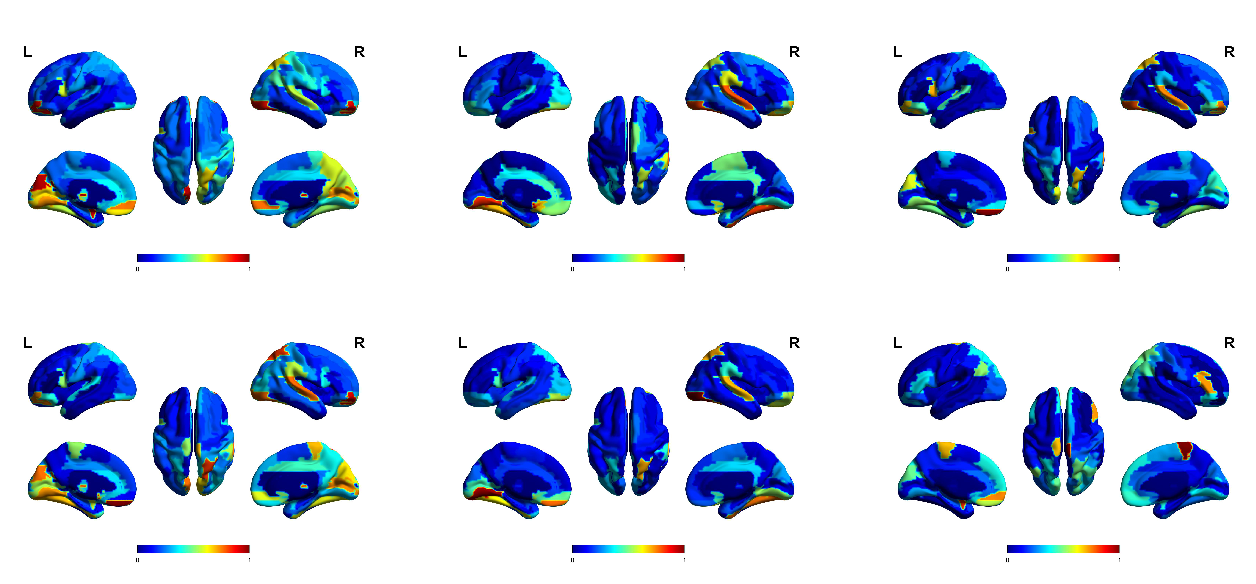

In [44]:
brainDir = Path("../plots/")
brainPlots = list(brainDir.glob(f"fMRIM8_{idx+1}*.jpg"))
brainPlots = sorted(brainPlots, key=lambda x: int(x.stem.split("_")[-1]))

fig = plt.figure(figsize=(18, 8), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)


ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])

axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for idx1, ax in enumerate(axs):
    img = plt.imread(brainPlots[idx1])
    ax.imshow(img)
    ax.axis("off")